<a href="https://colab.research.google.com/github/itchyfeet-patient/Beautiful-Exploration/blob/master/Exploration_9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **프로젝트 9 : 인물 모드 문제점 찾기 🧑**

라이브러리 버전 체크


In [ ]:
# pip install importlib-metadata
# pip install pixellib

In [ ]:
# !python -m pip install importlib-metadata

`from importlib.metadata import version` 이 실행되질 않아서... 고군분투함  
python 3.8버전 이하는 importlib_metadata로 사용해야 정상적으로 작동함... [참고](https://stackoverflow.com/questions/71684760/hello-when-i-open-my-terminal-in-ubuntu-i-found-this-erreur)


In [ ]:
import sys
print(sys.version)

3.7.13 (default, Apr 24 2022, 01:04:09) 
[GCC 7.5.0]


In [ ]:
from importlib_metadata import version
import cv2
import pixellib

print(cv2.__version__)
print(version('pixellib'))

4.6.0
0.7.1


In [ ]:
print(version('tensorflow'))
print(version('keras'))

2.6.0+zzzcolab20220506153740
2.6.0


In [ ]:
import os
import urllib # 웹에서 이미지를 다운로드 할 때 사용
import cv2 # opencv 라이브러리로 이미지를 처리하기 위해 필요
import numpy as np
from pixellib.semantic import semantic_segmentation # 시맨틱 세그멘테이션을 편하게 사용할 수 있는 라이브러리
from matplotlib import pyplot as plt


## **Step 1. 인물모드 직접 해 보기**
* 여러분의 셀카를 이용해서 오늘 배운 내용을 수행해 봅시다. 아래와 같은 이미지를 얻어야 합니다. 최소 3장 이상의 인물모드 사진을 만들어 봅시다.  
* 인물이 주인공이 아닌, 귀여운 고양이에 대한 아웃포커싱 사진도 만들어 볼 수 있을 것입니다. 시맨틱 세그멘테이션 스텝에서 힌트를 찾아봅시다.  
* 배경을 blur하는 인물모드 사진이 아니라 배경사진을 다른 이미지로 교체하는 크로마키 배경 합성을 시도해 볼 수도 있을 것입니다. 여러분만의 환상적인 사진을 만들어 보면 어떨까요?  

### 👧🏻 image 1 - profile 

(5763, 3842, 3)


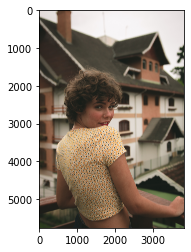

In [ ]:
img_path =  '/content/drive/MyDrive/dataset/human_segmentation/images/pexels-athena-1990241.jpg'
img_orig = cv2.imread(img_path) 

print(img_orig.shape)

plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
# 저장할 파일 이름을 결정합니다
model_dir = '/content/drive/MyDrive/dataset/human_segmentation/models'
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')

# PixelLib가 제공하는 모델의 url입니다
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5'

# 다운로드를 시작합니다
urllib.request.urlretrieve(model_url, model_file)

('/content/drive/MyDrive/dataset/human_segmentation/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
 <http.client.HTTPMessage at 0x7f71862fc850>)

다운로드 한 모델을 이용해 pixellib로 우리가 사용할 세그멘테이션 모델을 생성합니다.

In [ ]:
model = semantic_segmentation()
model.load_pascalvoc_model(model_file)

모델에 이미지 입력

In [ ]:
segvalues, output = model.segmentAsPascalvoc(img_path)

segmentAsPascalvoc라는 함수 이름에서 세그멘테이션 모델에 대한 힌트를 얻을 수 있는데요. PASCAL VOC 데이터로 학습된 모델을 이용한다는 의미입니다. 모델마다 학습시킨 데이터에 따라 결괏값이 달라지므로 어떤 데이터를 학습시켰는지 확인하는 것은 매우 중요합니다.  
PASCAL VOC 데이터의 라벨 종류는 아래와 같습니다.

In [ ]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

background를 제외하면 20개의 클래스가 있습니다. 따라서 20 의 의미는 tv 가 되겠네요! 0부터 시작하니까요.

우리는 이 중 사람(person) 라벨, 즉 15를 가진 영역만 검출해 내고 싶습니다. 이제 사람만 어떻게 추출할 수 있을지 알아봅시다.

아까 모델에서 나온 출력값을 살짝 살펴볼게요.

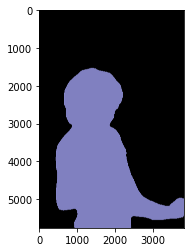

In [ ]:
plt.imshow(output)
plt.show()

In [ ]:
segvalues

{'class_ids': array([ 0, 15]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]])}

In [ ]:
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
person


output에는 세그멘테이션이 된 결과가 각각 다른 색상으로 담겨 있네요. segvalues에는 class_ids와 masks가 있습니다. class_ids를 통해 어떤 물체가 담겨 있는지 알 수 있군요!

이제 물체마다 output에 어떤 색상으로 나타나 있는지만 알아내면 될 것 같습니다.

In [ ]:
# 아래 코드를 이해하지 않아도 좋습니다
# PixelLib에서 그대로 가져온 코드입니다
# 주목해야 할 것은 생상 코드 결과물이예요!
colormap = np.zeros((256, 3), dtype = int) 
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20]

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

PixelLib에 따르면 위와 같은 색을 사용했다고 하네요. 그럼 사람을 나타내는 15번째 색상은 무엇일까요?

In [ ]:
colormap[15]

array([192, 128, 128])

사람 외에도 다른 물체를 찾아내고 싶다면 colormap[class_id]처럼 찾아낼 수 있겠네요!

여기서 주의할 것은 output 이미지가 BGR 순서로 채널 배치가 되어 있다는 점이에요. colormap은 RGB 순서이고요.

그러니 우리가 추출해야 하는 색상 값은 순서를 아래처럼 바꿔 줘야 합니다.



In [ ]:
seg_color = (128,128,192)

이제 seg_color로만 이루어진 마스크를 만들어 봅시다.

(5763, 3842)


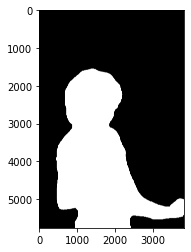

In [ ]:
# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 됩니다
seg_map = np.all(output==seg_color, axis=-1)
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()

어떤가요? 3채널 가졌던 원본과는 다르게 채널 정보가 사라졌습니다.

이제 아래처럼 물체가 있는 위치는 1(True), 그 외에는 0(False)인 배열이 되었습니다.

원래 이미지와 겹쳐 보면 세그멘테이션이 얼마나 잘 되었는지 알아보기 쉬울 것 같네요.

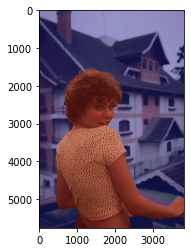

In [ ]:
img_show = img_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스크를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.

img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

이번에는 배경을 흐리게 만듭니다. blur() 함수를 이용합니다.

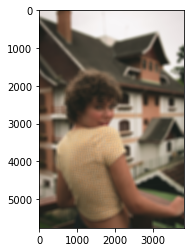

In [ ]:
# (13,13)은 blurring kernel size를 뜻합니다
# 다양하게 바꿔보세요
img_orig_blur = cv2.blur(img_orig, (100,100))  
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

흐려진 이미지에서 세그멘테이션 마스크를 이용해서 배경만 추출하겠습니다.

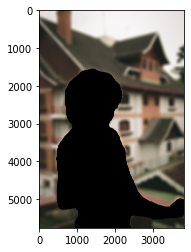

In [ ]:
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

bitwise_not 함수를 이용하면 이미지가 반전됩니다. 원래 마스크에서는 배경이 0, 사람이 255였으니 bitwise_not 연산을 하고 나면 배경은 255, 사람은 0이 되겠죠?

반전된 세그멘테이션 결과를 이용해서 이미지와 bitwise_and 연산을 수행하면 배경만 있는 영상을 얻을 수 있습니다. 0과 어떤 수를 bitwise_and 연산을 해도 0이 되기 때문에 사람이 0인 경우에는 사람이 있던 모든 픽셀이 0이 됩니다. 결국 사람이 사라지게 되는 거죠.

이제 배경 영상과 사람 영상을 합치기만 하면 되겠죠?

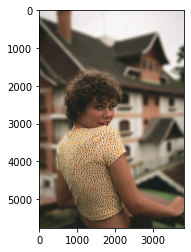

In [ ]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

세그멘테이션 마스크가 255인 부분만 원본 이미지 값을 가지고 오고 아닌 영역은 블러된 이미지 값을 사용합니다. np.where(조건, 참일때, 거짓일때)의 형식의 코드를 사용했네요.

### 🧍🏻‍♂️ image 2 - full body shot

(4096, 2730, 3)


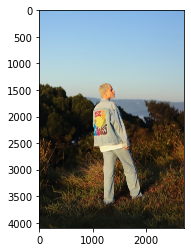

In [ ]:
img_path =  '/content/drive/MyDrive/dataset/human_segmentation/images/pexels-nickmans-gabriel-12317767.jpg'
img_orig = cv2.imread(img_path) 

print(img_orig.shape)

plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
# 저장할 파일 이름을 결정합니다
model_dir = '/content/drive/MyDrive/dataset/human_segmentation/models'
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')

# PixelLib가 제공하는 모델의 url입니다
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5'

# 다운로드를 시작합니다
urllib.request.urlretrieve(model_url, model_file)

('/content/drive/MyDrive/dataset/human_segmentation/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
 <http.client.HTTPMessage at 0x7f717c493f90>)

다운로드 한 모델을 이용해 pixellib로 우리가 사용할 세그멘테이션 모델을 생성합니다.

In [ ]:
model = semantic_segmentation()
model.load_pascalvoc_model(model_file)

모델에 이미지 입력

In [ ]:
segvalues, output = model.segmentAsPascalvoc(img_path)

segmentAsPascalvoc라는 함수 이름에서 세그멘테이션 모델에 대한 힌트를 얻을 수 있는데요. PASCAL VOC 데이터로 학습된 모델을 이용한다는 의미입니다. 모델마다 학습시킨 데이터에 따라 결괏값이 달라지므로 어떤 데이터를 학습시켰는지 확인하는 것은 매우 중요합니다.  
PASCAL VOC 데이터의 라벨 종류는 아래와 같습니다.

In [ ]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

background를 제외하면 20개의 클래스가 있습니다. 따라서 20 의 의미는 tv 가 되겠네요! 0부터 시작하니까요.

우리는 이 중 사람(person) 라벨, 즉 15를 가진 영역만 검출해 내고 싶습니다. 이제 사람만 어떻게 추출할 수 있을지 알아봅시다.

아까 모델에서 나온 출력값을 살짝 살펴볼게요.

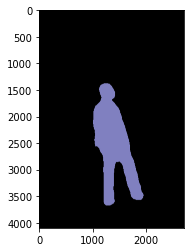

In [ ]:
plt.imshow(output)
plt.show()

In [ ]:
segvalues

{'class_ids': array([ 0, 15]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]])}

In [ ]:
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
person


output에는 세그멘테이션이 된 결과가 각각 다른 색상으로 담겨 있네요. segvalues에는 class_ids와 masks가 있습니다. class_ids를 통해 어떤 물체가 담겨 있는지 알 수 있군요!

이제 물체마다 output에 어떤 색상으로 나타나 있는지만 알아내면 될 것 같습니다.

In [ ]:
# 아래 코드를 이해하지 않아도 좋습니다
# PixelLib에서 그대로 가져온 코드입니다
# 주목해야 할 것은 생상 코드 결과물이예요!
colormap = np.zeros((256, 3), dtype = int) 
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20]

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

PixelLib에 따르면 위와 같은 색을 사용했다고 하네요. 그럼 사람을 나타내는 15번째 색상은 무엇일까요?

In [ ]:
colormap[15]

array([192, 128, 128])

사람 외에도 다른 물체를 찾아내고 싶다면 colormap[class_id]처럼 찾아낼 수 있겠네요!

여기서 주의할 것은 output 이미지가 BGR 순서로 채널 배치가 되어 있다는 점이에요. colormap은 RGB 순서이고요.

그러니 우리가 추출해야 하는 색상 값은 순서를 아래처럼 바꿔 줘야 합니다.



In [ ]:
seg_color = (128,128,192)

이제 seg_color로만 이루어진 마스크를 만들어 봅시다.

(4096, 2730)


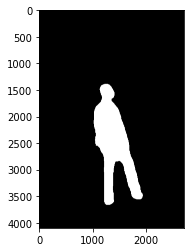

In [ ]:
# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 됩니다
seg_map = np.all(output==seg_color, axis=-1)
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()

어떤가요? 3채널 가졌던 원본과는 다르게 채널 정보가 사라졌습니다.

이제 아래처럼 물체가 있는 위치는 1(True), 그 외에는 0(False)인 배열이 되었습니다.

원래 이미지와 겹쳐 보면 세그멘테이션이 얼마나 잘 되었는지 알아보기 쉬울 것 같네요.

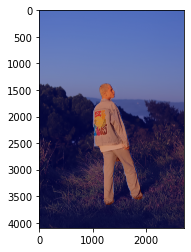

In [ ]:
img_show = img_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스크를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.

img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

이번에는 배경을 흐리게 만듭니다. blur() 함수를 이용합니다.

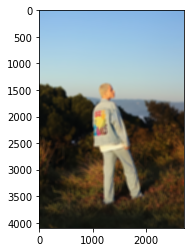

In [ ]:
# (13,13)은 blurring kernel size를 뜻합니다
# 다양하게 바꿔보세요
img_orig_blur = cv2.blur(img_orig, (50,50))  
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

흐려진 이미지에서 세그멘테이션 마스크를 이용해서 배경만 추출하겠습니다.

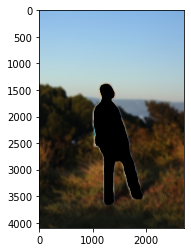

In [ ]:
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

bitwise_not 함수를 이용하면 이미지가 반전됩니다. 원래 마스크에서는 배경이 0, 사람이 255였으니 bitwise_not 연산을 하고 나면 배경은 255, 사람은 0이 되겠죠?

반전된 세그멘테이션 결과를 이용해서 이미지와 bitwise_and 연산을 수행하면 배경만 있는 영상을 얻을 수 있습니다. 0과 어떤 수를 bitwise_and 연산을 해도 0이 되기 때문에 사람이 0인 경우에는 사람이 있던 모든 픽셀이 0이 됩니다. 결국 사람이 사라지게 되는 거죠.

img_bg 결과

이제 배경 영상과 사람 영상을 합치기만 하면 되겠죠?

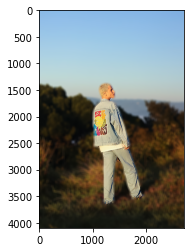

In [ ]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

세그멘테이션 마스크가 255인 부분만 원본 이미지 값을 가지고 오고 아닌 영역은 블러된 이미지 값을 사용합니다. np.where(조건, 참일때, 거짓일때)의 형식의 코드를 사용했네요.

### 🐱 image 3 - cat

(4075, 6112, 3)


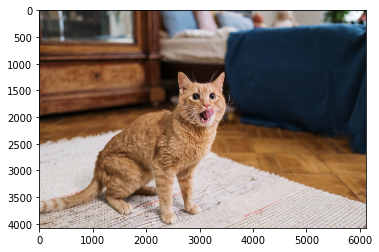

In [ ]:
img_path =  '/content/drive/MyDrive/dataset/human_segmentation/images/pexels-cottonbro-6864664.jpg'
img_orig = cv2.imread(img_path) 

print(img_orig.shape)

plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
# 저장할 파일 이름을 결정합니다
model_dir = '/content/drive/MyDrive/dataset/human_segmentation/models'
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')

# PixelLib가 제공하는 모델의 url입니다
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5'

# 다운로드를 시작합니다
urllib.request.urlretrieve(model_url, model_file)

('/content/drive/MyDrive/dataset/human_segmentation/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
 <http.client.HTTPMessage at 0x7f717b496750>)

다운로드 한 모델을 이용해 pixellib로 우리가 사용할 세그멘테이션 모델을 생성합니다.

In [ ]:
model = semantic_segmentation()
model.load_pascalvoc_model(model_file)

모델에 이미지 입력

In [ ]:
segvalues, output = model.segmentAsPascalvoc(img_path)

segmentAsPascalvoc라는 함수 이름에서 세그멘테이션 모델에 대한 힌트를 얻을 수 있는데요. PASCAL VOC 데이터로 학습된 모델을 이용한다는 의미입니다. 모델마다 학습시킨 데이터에 따라 결괏값이 달라지므로 어떤 데이터를 학습시켰는지 확인하는 것은 매우 중요합니다.  
PASCAL VOC 데이터의 라벨 종류는 아래와 같습니다.

In [ ]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

background를 제외하면 20개의 클래스가 있습니다. 따라서 20 의 의미는 tv 가 되겠네요! 0부터 시작하니까요.

우리는 이 중 고영(cat) 라벨, 즉 8을 가진 영역만 검출해 내고 싶습니다. 이제 고영만 어떻게 추출할 수 있을지 알아봅시다.

아까 모델에서 나온 출력값을 살짝 살펴볼게요.

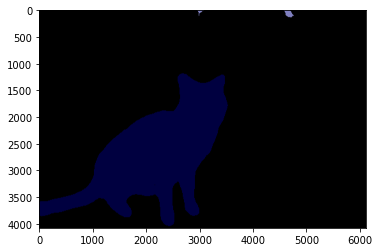

In [ ]:
plt.imshow(output)
plt.show()

In [ ]:
segvalues

{'class_ids': array([ 0,  8, 15]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]])}

In [ ]:
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
cat
person


output에는 세그멘테이션이 된 결과가 각각 다른 색상으로 담겨 있네요. segvalues에는 class_ids와 masks가 있습니다. class_ids를 통해 어떤 물체가 담겨 있는지 알 수 있군요!

이제 물체마다 output에 어떤 색상으로 나타나 있는지만 알아내면 될 것 같습니다.

In [ ]:
# 아래 코드를 이해하지 않아도 좋습니다
# PixelLib에서 그대로 가져온 코드입니다
# 주목해야 할 것은 생성 코드 결과물이예요!
colormap = np.zeros((256, 3), dtype = int) 
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20]

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

PixelLib에 따르면 위와 같은 색을 사용했다고 하네요. 그럼 고영을 나타내는 8번째 색상은 무엇일까요?

In [ ]:
colormap[8]

array([64,  0,  0])

고영의 색상은 64,0,0 입니다.  
BGR 순서니까 RGB 순서로 바꿔줄게요. (0, 0, 64)

In [ ]:
seg_color = (0, 0, 64)

이제 seg_color로만 이루어진 마스크를 만들어 봅시다.

(4075, 6112)


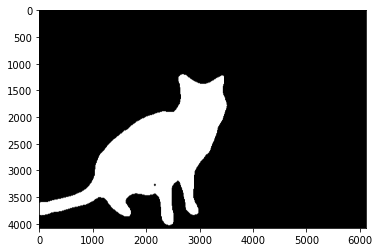

In [ ]:
# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 됩니다
seg_map = np.all(output==seg_color, axis=-1)
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()

어떤가요? 3채널 가졌던 원본과는 다르게 채널 정보가 사라졌습니다.

이제 아래처럼 물체가 있는 위치는 1(True), 그 외에는 0(False)인 배열이 되었습니다.

원래 이미지와 겹쳐 보면 세그멘테이션이 얼마나 잘 되었는지 알아보기 쉬울 것 같네요.

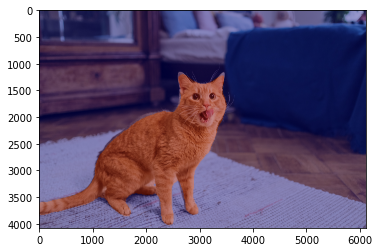

In [ ]:
img_show = img_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스크를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.

img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

잘 분리되었네요?

이번에는 배경을 흐리게 만듭니다. blur() 함수를 이용합니다.

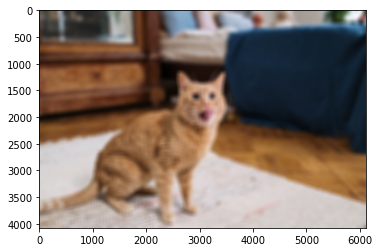

In [ ]:
# blurring kernel size = 100
img_orig_blur = cv2.blur(img_orig, (100,100))  
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

흐려진 이미지에서 세그멘테이션 마스크를 이용해서 배경만 추출하겠습니다.

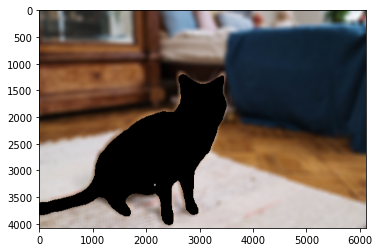

In [ ]:
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

bitwise_not 함수를 이용해서 이미지가 반전되었습니다. 원래 마스크에서는 배경이 0, 고영이 255였으니 bitwise_not 연산을 하고 나면 배경은 255, 고영은 0이 되겠죠?

반전된 세그멘테이션 결과를 이용해서 이미지와 bitwise_and 연산을 수행하면 배경만 있는 영상을 얻을 수 있습니다. 0과 어떤 수를 bitwise_and 연산을 해도 0이 되기 때문에 고양이가 0인 경우에는 고양이가 있던 모든 픽셀이 0이 됩니다. 결국 고영이 사라지게 되는 거죠.

배경 영상과 고양이 영상을 합치겠습니다.

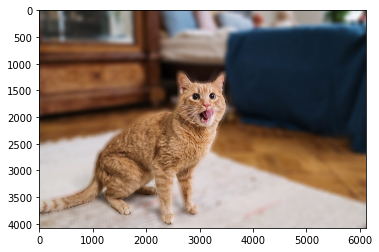

In [ ]:
img_concat = np.where(img_mask_color==255, img_orig, img_orig_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

완성!

---

고양이가 츄르를 먹고싶어 하는 것 같아서 배경을 츄르먹는 고양이로 바꿔보겠습니당.

(468, 499, 3)


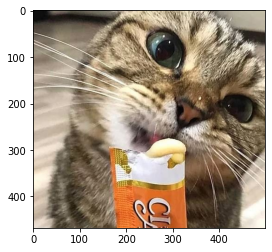

In [ ]:
img_path =  '/content/drive/MyDrive/dataset/human_segmentation/images/Chao.jpg'
img_ciao = cv2.imread(img_path) 
print(img_ciao.shape)

plt.imshow(cv2.cvtColor(img_ciao, cv2.COLOR_BGR2RGB))
plt.show()

츄르먹는 고양이를 데려왔습니다. 귀엽습니다. 

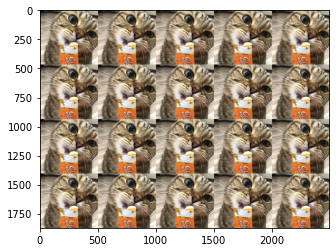

(4075, 6112, 3)

In [ ]:
def img_tile(img_list):
    return cv2.vconcat([cv2.hconcat(img) for img in img_list])

img_tile_res = img_tile( [[img_ciao]*5, [img_ciao]*5, [img_ciao]*5, [img_ciao]*5 ])
plt.imshow(cv2.cvtColor(img_tile_res, cv2.COLOR_BGR2RGB))
img_tile_res = cv2.resize(img_tile_res,(6112, 4075) ) 

plt.show() # (1404,1996,3)
img_tile_res.shape



사진을 세로로 붙여주는 `vcconcat` 와 가로로 붙여주는 `hconcat` 를 사용해서 함수 img_tile 생성, 가로세로 이미지 개수는 적절히 조절해줬습니다.  
밑에서 원본 고영 사진과 붙여줘야 하니 해당 이미지에 맞춰 `resize` 했습니다.

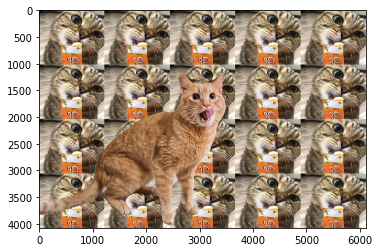

In [ ]:
img_concat = np.where(img_mask_color==255, img_orig, img_tile_res)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

**작품명 : 츄르가 먹고싶은 고영 🐈**    
 완성!

배경이 정신사나워서 누끼가 깔끔하게 따지지 않은 것도 아무도 모를것 같아요. (오히려좋아)

## **Step 2. 문제점 찾기**


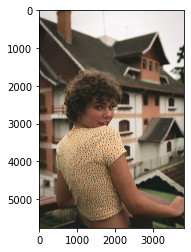

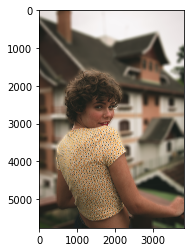

문제점 : 사람이 난간을 잡고 있는데 사람만 인식되어 masking되니 난간은 blur 처리되어버린다..  
👉 물체 중심의 인식보다는 심도를 계산하여 처리할 수 있다면 좋을텐데

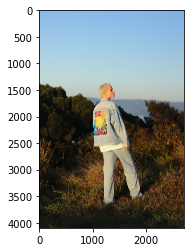

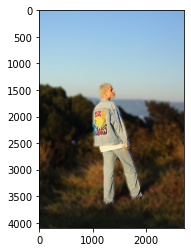

문제점 : 이건 거의 다 그렇겠지만 경계가 잘 분리되지 않아서 (누끼가 정확하게 안 따져서) 블러처리 하니까 경계가 블러링 되어 뭔가 아련한 분위기 연출  
👉 semantic segmentation의 한계인듯? 요즘 누끼 따주는 사이트도 있던데 그런 알고리즘을 가져와서 인식한 물체(ex. person)를 보다 더 잘 분리할 수 있는 방법으로 가면 좋겠다.

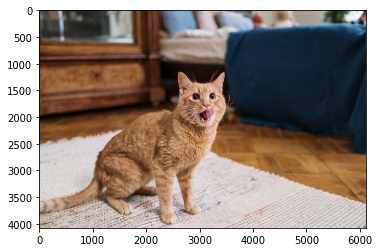

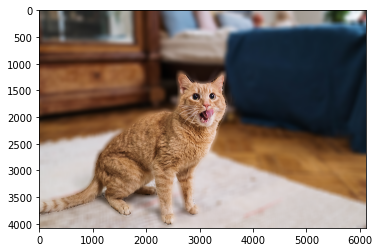

문제점 : 이건 비단 여기서뿐 아니라 누끼따기 힘든 사진 중 하나인 '털'이라서 발생하는 문제. 고양이 수염? 같은 가느다란 털이 인식되지 못했다.  
👉 image 2의 해결책과 같을것이야

## **Step 3. 해결 방법을 제안해 보기**  
아주 간단히 멋진 카메라 앱 서비스를 만들어 출시할 수 있을 것 같았지만, 지금 같은 완성도로는 어림도 없습니다. 소비자들의 눈높이는 그리 호락호락하지 않고, 엔지니어인 여러분들은 답을 찾아내야 합니다.  

생각해 볼 만한 주제를 아래에 몇 가지 제시해 봅니다. 아래를 읽어본 후, 여러분이 만든 인물모드 사진의 문제점을 해결할 방안을 정리하여 제안해 주시기 바랍니다.
단순히 'XXX 기술을 사용한다.' 정도의 선언적 솔루션이 아니라, **여러분들이 선택한 기술이 DeepLab 모델의 Semantic Segmentation 이 만들어 낸 Mask 영역에 어떻게 적용되어 문제점을 보완하게 되는지의 메커니즘이 포함된 솔루션**이어야 합니다.  

참고  
* 얕은 피사계 심도 촬영하는 법  
    1. 이미지센서가 크면 클수록  
        클수록 카메라가 빛을 받아들이는 면적이 커져 심도가 얕아짐.
    2. 망원렌즈 사용하기  
        렌즈의 초점 거리가 멀어지면 심도는 얕아짐.
    3. 조리개가 많이 개방될 수록
        조리개를 많이 개방하면 개방할 수록 빛을 많이 받아들일 수 있어 심도가 얕아짐.
    4. 카메라와 피사체간의 거리가 가까울 때  
    5. 피사체와 배경과의 거리가 멀수록
        아무래도 배경이 피사체와 멀리 떨어져 있을수록 잘 됨


### 해결방법 (1)

image 2, 3의 문제점에서 개체는 잘 인식했으나 누끼가 제대로 따지지 않아서 결과물에 영향이 있었습니다. 


[누끼 따주는 사이트](https://www.remove.bg/ko) 를 참고해서 이 사이트에서 따진 누끼와 합쳐보겠습니다.

일단 해당 사이트에서 image 3 귀여운 고양이의 누끼를 한 번 따봤습니다.

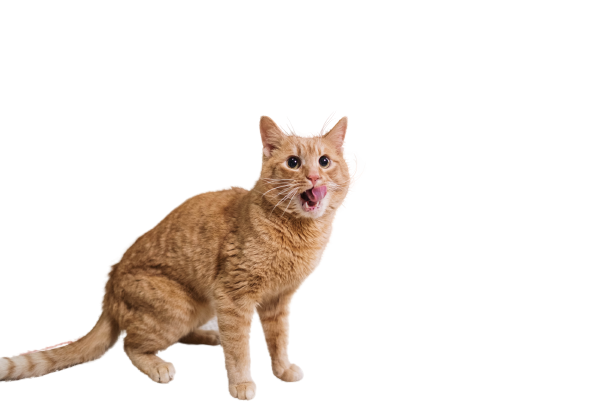

배경이 없어지니까 더 귀엽습니다.  
그냥 봐도 귀 옆 털까지 세밀하게 따진 것을 볼 수 있습니다. (기술의 발전)

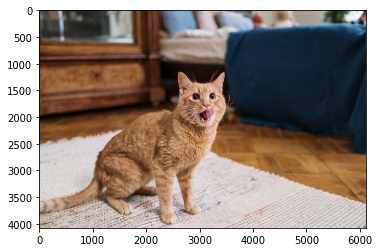

(408, 612, 3)
(4075, 6112, 3)


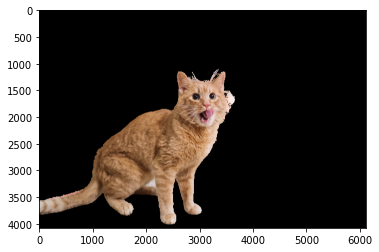

In [ ]:
img_path =  '/content/drive/MyDrive/dataset/human_segmentation/images/pexels-cottonbro-6864664-removebg-preview.png'
# 누끼따주는 사이트에서 딴 이미지
img_removed = cv2.imread(img_path)

print(img_removed.shape)
print(img_orig_blur.shape)
img_removed = cv2.resize(img_removed,(6112, 4075)) # 사이즈를 원본 이미지와 같게 맞춰줌!
plt.imshow(cv2.cvtColor(img_removed, cv2.COLOR_BGR2RGB))
plt.show()

위에서는 segmentation으로 자동으로 따진 마스크를 이용했지만, 이번에는 직접 이미지를 불러온 것이므로 직접 마스크를 만들어 줍니다.  
누끼 딴 이미지 imge_removed는 배경이 투명해서 배경 부분은 BRGA 의 A값이 0입니다. 배경이 아닌 부분은 A가 0이 아니겠죠. 따라서 A가 1 이상이면 255, 1 미만이면 0으로 바꿔줍니다. mask_inv는 반전시킨 건데 혹시몰라서 적어놨습니다.

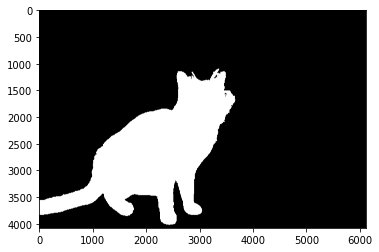

In [ ]:
_, mask = cv2.threshold(img_removed[:,:,2], 1, 255, cv2.THRESH_BINARY)
mask_inv = cv2.bitwise_not(mask)
plt.imshow(mask, cmap='gray')
plt.show()

In [ ]:
print(mask.shape)
print(img_show.shape)

(4075, 6112)
(4075, 6112, 3)


이번에는 배경을 흐리게 만듭니다. blur() 함수를 이용합니다.

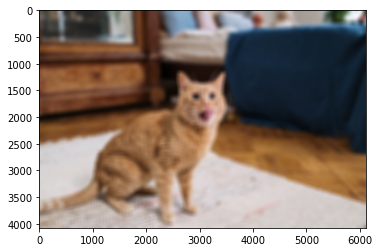

In [ ]:
# blurring kernel size = 100
img_orig_blur = cv2.blur(img_orig, (100,100))  
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

흐려진 이미지에다가 새 고영이 누끼를 이용해 만든 마스크를 이용해 배경만 추출하겠습니다.

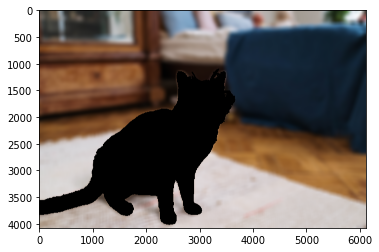

In [ ]:
img_mask_color = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

합쳐줍니다.

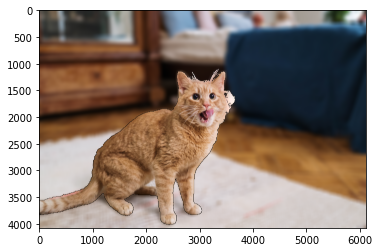

In [ ]:
#img_removed = cv2.resize(img_removed,(6112, 4075)) 
img_concat = np.where(img_mask_color==255, img_removed, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

경계부분이 확실히 더 선명해졌습니다. 유격?인지 검은 선이 보이는데 고건 모르겠습니다... (따흑)

---  

이렇게 누끼따는 사이트에서 따온 이미지를 활용해서 이미지를 병합시켰더니 더 선명해졌습니다.

### **🤔 image 2, 3 사례 해결책**
image 2, 3의 사례에서 제가 생각한 해결책은 위에서 보셨듯  
1. segmentation으로 개체들을 식별, 라벨링한다. 
2. 원하는 객체를 선택하고, 해당 객체만 따올 수 있게 누끼따는 사이트에 넣고 돌린다.
3. 해당 이미지로 마스크를 만든다.
4. 만들어진 마스크로 blur 처리된 원본에서 마스크 부분을 제거시킨다.
5. 배경 + 누끼 따진 이미지 합쳐준다.  

---

### **🤔 image 1 사례 해결책**
image 1의 사례에서는 사람만 인식해서 심도가 같은 개체를 인식하지 못하고 blur 처리되어 버린다는 것이었습니다.  
* 제 생각에 현재로서는 심도를 잘 인식할 수 있는 기술을 사용해서 각각의 심도를** 계산하고 그것을 바탕으로 마스크를 만들어 blur 처리**를 하는 게 어떤가 생각이 듭니다.   
* [구글, 심도 예측 가능한 딥러닝 솔루션 개발](http://www.bulmanzero.com/news/articleView.html?idxno=27620)  
    해당 기사를 참고하면 구글에서 사진 뿐 아니라 동영상에서 심도를 측정할 수 있는 기술을 개발했다고 밝혔습니다. 기사 내 등장하는 **'synthetic defocus'** 효과 역시 동영상에 아웃포커싱 효과를 인공적으로 적용할 수 있다는 내용이므로, 충분히 가능한 기술이라고 생각됩니다.

---

## 🎯 평가 루브릭
| **평가문항** | **상세기준** | **학습결과** |
|:---:|---|:---:|
| 1. 인물모드 사진을 성공적으로 제작하였다. | 아웃포커싱 효과가 적용된 본인의 인물모드 사진과 고양이 사진, 배경전환 크로마키사진을 각각 1장 이상 성공적으로 제작하였다. | O |
| 2. 제작한 인물모드 사진들에서 나타나는 문제점을 정확히 지적하였다. | 인물사진에서 발생한 문제점을 정확히 지적한 사진을 제출하였다. | O |
| 3. 인물모드 사진의 문제점을 개선할 수 있는 솔루션을 적절히 제시하였다. | 추가적인 depth 정보를 활용하여 semantic segmentation mask의 오류를 보완할 수 있는 좋은 솔루션을 구체적으로 제시하였다. | O |

## ✍ 회고

1. CV 의외로(?) 재미지다. 근데 가끔 맞게 했다고 생각했는데 결과는 내 생각대로 안나올 때 많았음..
2. 예전에 필름카메라 살짝 만져봤는데 아웃포커싱 사진 찍으려고 이것저것 찾아본 기억이 새록새록 나는 EX였다. DOF 계산도 해보고 조도계? 어플도 다운받았었제
3. 제일 처음에 version 확인하는 importlib 인가 그거 꼭 필요한 거 아닌데 안돼서 한 한시간쯤 찾아본듯.. 난 꼭 필요한건줄 알았지.. ㅎㅎ (멍청) 암튼 파이썬 버전문제였다.
4. 무성님의 도움으로 semantic segmentation import 성공 (+명찬님).. 🙏 처음에 stackoverflow 뒤져서 tensorflow downgrade는 했는데 keras도 downgrade 해야한다는 사실을 잊었지모야 ㅎ
5. 고양이 누끼 따와서 블러된 배경에 **얹으면(?) 된다고 생각했는데 오산**이었다.........(진짜)   
    왜나면 open cv에서는 이미지 위에 이미지 얹는거 없거든요. **add 연산은 말 그대로 연산**이다. 픽셀연산이라서 내가 원하는 결과가 절대로 안나옴. 그것도 모르고 add 했는데 왜 사진이 안 합쳐지지(?)   
    노드 제대로 안봤죠? 위에 다 나오는데 대충봤죠? ㅎㅎ 왜 bitwise 연산을 했겠어... 
6. 누끼따는 사이트 의외로 잘 따져서 놀랐다. 초딩때 포토샵으로 하나하나 땄는데.. 세상..
7. 무료 사진 사이트 '[Pexels](https://www.pexels.com/ko-kr/)' 여기 고퀄 사진 많다. 추천!
8. 고양이 너무 귀엽다. 내 회심의 역작 '츄르가 먹고싶은 고영' 많이 봐줬으면 좋겠다. 감상평 아지트 DM으로 보내주면 좋겠다.

### 참고자료  

* image_1 : athena 님의 사진, 출처 : [Pexels](https://www.pexels.com/ko-kr/)  
* imgae_2 : nickmans-gabriel 님의 사진, 출처 : [Pexels](https://www.pexels.com/ko-kr/)    
* image_3 : cottonbro 님의 사진, 출처: [Pexels](https://www.pexels.com/ko-kr/)  
* img_ciao : 츄르먹는 고앵이 , 출처 : [naver](https://m.post.naver.com/viewer/postView.naver?volumeNo=30309855&memberNo=2247263)
* img_tile : cv로 바둑판 배열 출력 , 출처 : [github](https://github.com/mafls122/Python_openCV/blob/main/openCV_03.py)  
* 마스크 생성과정, 이미지 병합 (도움이 정말 많이 되었어요), 출처 : [tistory](https://bkshin.tistory.com/entry/OpenCV-9-%EC%9D%B4%EB%AF%B8%EC%A7%80-%EC%97%B0%EC%82%B0)
